# Modeling Wavelength Response of the MOXSI Detectors

In [83]:
import sys
import copy

import astropy.units as u
import astropy.constants as const
import astropy.io.fits
import astropy.wcs
from ndcube import NDCube
from astropy.visualization import quantity_support
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from aiapy.response import Channel as AIAChannel

from roentgen.absorption import Material, Response

sys.path.append('../simulation_pipeline/detector/')
from response import Channel, SpectrogramChannel

## Response Function Comparison

In [2]:
selected_filters = [
    'Be_thin',
    'Be_med',
    'Be_thick',
    'Al_poly',
]
chan_filename = '../simulation_pipeline/data/MOXSI_effarea.genx'
pinholes = [Channel(f, chan_filename) for f in selected_filters]
dispersed_orders = [SpectrogramChannel(o, chan_filename) for o in [0,1,3]]

In [50]:
for p in pinholes:
    print(f'{p.name}: {p._data["filter_desc"]}')

Be_thin: 9 micron Be filter / XRT thin Be - no support
Be_med: 30 micron Be filter / XRT med Be - no support
Be_thick: 300 micron Be filter / XRT thick Be - no support
Al_poly: 1.25 micron Al filter * 2.5 micron Poly / XRT Al-Poly


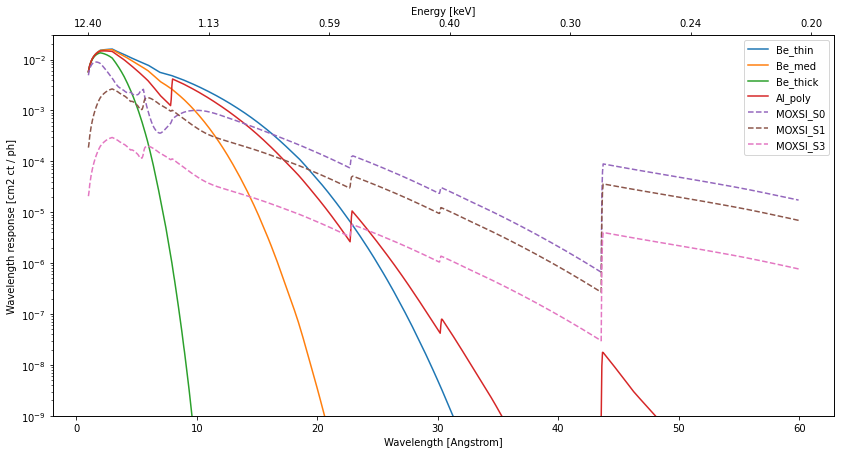

In [77]:
fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(111)
#ax2 = ax.twiny()
for p in pinholes:
    ax.plot(p.wavelength, p.wavelength_response, label=p.name)
    #energy = const.h * const.c / p.wavelength
    #ax2.plot(energy.to('keV'), p.wavelength_response)
for d in dispersed_orders:
    ax.plot(d.wavelength, d.wavelength_response, label=d.name, ls='--')
ax.legend()
ax.set_yscale('log')
ax.set_ylim(1e-9,0.03)
#ax.set_xlim(p.wavelength[[0,-1]].to_value('angstrom'))

energy_ticks = lambda x: [f"{(const.h * const.c / (_x*u.angstrom)).to_value('keV'):.2f}" for _x in x]

#energy_even = np.logspace(-1,1,10) * u.keV

#new_tick_locations = (const.h * const.c / energy_even).to_value('angstrom')

new_tick_locations = range(1,70,10)

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(energy_ticks(new_tick_locations));

ax.set_ylabel(f'Wavelength response [{p.wavelength_response.unit}]')
ax.set_xlabel(f'Wavelength [{p.wavelength.unit}]')
ax2.set_xlabel('Energy [keV]');

In [52]:
def read_cube(filename, hdu=0):
    with astropy.io.fits.open(filename) as hdul:
        data = hdul[hdu].data
        header = hdul[hdu].header
        header.pop('KEYCOMMENTS', None)
        wcs = astropy.wcs.WCS(header=header)
        spec_cube = NDCube(data, wcs=wcs, meta=header, unit=header.get('BUNIT', None))
    return spec_cube

In [54]:
spectral_cube = read_cube('../simulation_pipeline/spectral-cube-example.fits', hdu=1)

In [64]:
def convolve_with_response(cube, channel):
    """
    Convolve spectral cube with wavelength response to convert spectra to instrument units.
    
    Parameters
    ----------
    cube : `ndcube.NDCube`
    channel : `Channel`
    
    Return
    ------
    : `ndcube.NDCube`
        Spectral cube in detector units convolved with instrument response
    """
    CDELT_SPACE = 5.66 * u.arcsec / u.pix
    CDELT_WAVE = 55 * u.milliangstrom / u.pix
    # FIXME: this should go in the Channel object
    plate_scale = CDELT_SPACE * CDELT_SPACE * u.pix
    # Interpolate wavelength response to wavelength array of spectral cube
    # NOTE: should this be done in reverse?
    wavelength = cube.axis_world_coords(0)[0].to_value('Angstrom')
    f_response = interp1d(channel.wavelength.to_value('Angstrom'),
                          channel.wavelength_response.to_value(),
                          bounds_error=False,
                          fill_value=0.0,)  # Response is 0 outside of the response range
    response = u.Quantity(f_response(wavelength), channel.wavelength_response.unit)
    response *= plate_scale
    response *= CDELT_WAVE * u.pix
    
    # Multiply by spectral cube
    data = (cube.data.T * cube.unit * response).T.sum(axis=0)
    
    meta = copy.deepcopy(cube.meta)
    meta['channel_name'] = channel.name
    
    return NDCube(data.to('ct pix-1 s-1'), wcs=cube[0].wcs, meta=meta)

In [69]:
pinhole_images = []
for p in pinholes:
    pinhole_images.append(convolve_with_response(spectral_cube, p))

In [78]:
from astropy.visualization import ImageNormalize, LogStretch
import sunpy.map

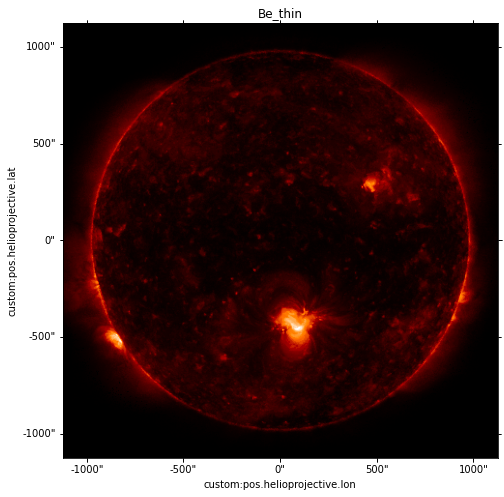

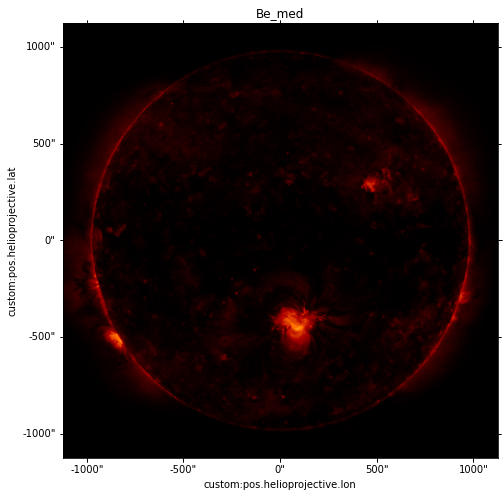

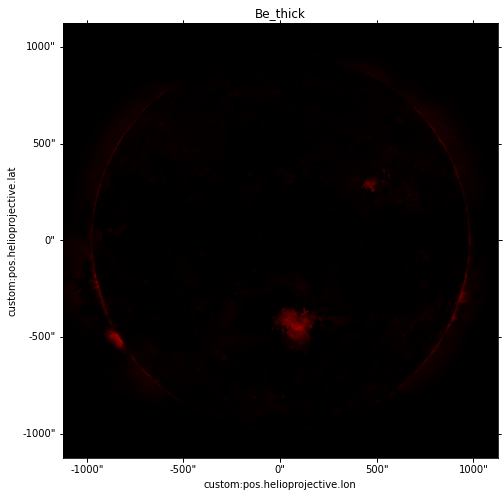

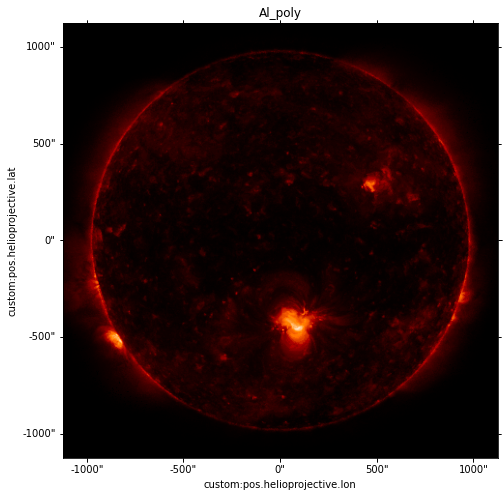

In [80]:
norm = ImageNormalize(vmin=0,vmax=50,stretch=LogStretch())
for pi in pinhole_images:
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection=pi.wcs)
    pi.plot(axes=ax,norm=norm,cmap='hinodexrt')
    ax.set_title(pi.meta['channel_name'])

In [84]:
aia_channels = [AIAChannel(c) for c in [94,131,171,193,211,335]*u.angstrom]

In [87]:
aia_channels[0].wavelength_response()

<Quantity [3.9164862e-11, 3.8051628e-11, 3.6971336e-11, ..., 1.0127668e-12,
           1.0095941e-12, 1.0064342e-12] cm2 ct / ph>

In [ ]:
aia_images = [convolve_with_response(spectral_cube, ac) for ac in aia_channels]

## Dispersed Channel

Look first at our current approach to modeling wave response

In [3]:
chan = SpectrogramChannel(1, '../simulation_pipeline/data/MOXSI_effarea.genx')

In [24]:
for c in chan._instrument_data['SAVEGEN0']:
    print(c['CHANNEL'])
    print('--------------')
    print('Filter:',c['FILTER_DESC'])
    print('Detector:',c['DET_DESC'])
    print('\n')

MOXSI_S0
--------------
Filter: 100 nm of Al based on conversation with Amir 11/11/20
Detector: Assumed based on transimission of Si


MOXSI_S1
--------------
Filter: 100 nm of Al based on conversation with Amir 11/11/20
Detector: Assumed based on transimission of Si


MOXSI_S3
--------------
Filter: 100 nm of Al based on conversation with Amir 11/11/20
Detector: Assumed based on transimission of Si


MOXSI_S5
--------------
Filter: 100 nm of Al based on conversation with Amir 11/11/20
Detector: Assumed based on transimission of Si


Be_thin
--------------
Filter: 9 micron Be filter / XRT thin Be - no support
Detector: Assumed based on transimission of Si


Be_med
--------------
Filter: 30 micron Be filter / XRT med Be - no support
Detector: Assumed based on transimission of Si


Be_thick
--------------
Filter: 300 micron Be filter / XRT thick Be - no support
Detector: Assumed based on transimission of Si


Al_poly
--------------
Filter: 1.25 micron Al filter * 2.5 micron Poly / XRT Al

In [25]:
al = Material('Al', 100*u.nm)

In [26]:
energy = const.h * const.c / chan.wavelength

Clearly there is some additional component here that causes the drop off starting at $\approx15\mathrm{\mathring{A}}$

In [73]:
energy.to('keV')

<Quantity [12.398419  , 11.752057  , 11.169746  , ...,  0.20715821,
            0.20696802,  0.20677817] keV>

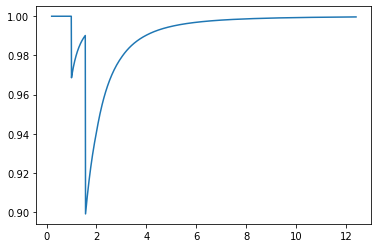

In [76]:
plt.plot(energy.to('keV'), al.transmission(energy))
plt.xlim()

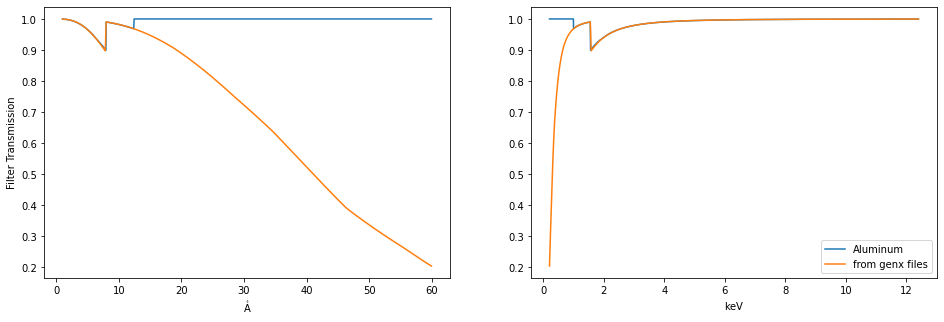

In [45]:
plt.figure(figsize=(16,5))
plt.subplot(121)
with quantity_support():
    plt.plot(wavelength, al.transmission(energy), label=f'{al.name}')
    plt.plot(wavelength, chan.filter_transmission, label='from genx files')
plt.ylabel(f'Filter Transmission')
plt.subplot(122)
with quantity_support():
    plt.plot(energy.to('keV'), al.transmission(energy), label=f'{al.name}')
    plt.plot(energy.to('keV'), chan.filter_transmission, label='from genx files')
plt.legend()

What is the assumed thickness here? Are there other materials? Shouldn't this be absorption rather than transmission?

In [67]:
si = Material('Si', 500*u.micron)

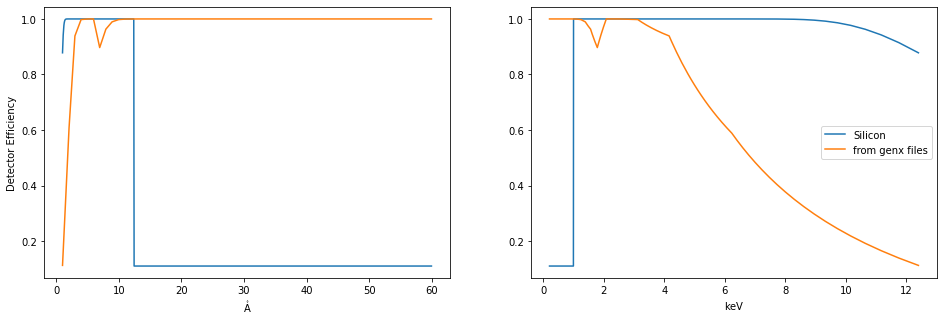

In [68]:
plt.figure(figsize=(16,5))
plt.subplot(121)
with quantity_support():
    plt.plot(wavelength, si.absorption(energy), label=f'{si.name}')
    plt.plot(wavelength, chan.detector_efficiency, label='from genx files')
plt.ylabel(f'Detector Efficiency')
plt.subplot(122)
with quantity_support():
    plt.plot(energy.to('keV'), si.absorption(energy), label=f'{si.name}')
    plt.plot(energy.to('keV'), chan.detector_efficiency, label='from genx files')
plt.legend()

Try using the `roentgen.material.Response` object

In [69]:
materials = [
    Material('al', 100*u.nm),
]
detector = Material('si', 500*u.micron)
response = Response(materials, detector)

In [70]:
chan.detector_efficiency * chan.filter_transmission

<Quantity [0.1122307 , 0.13868237, 0.16513062, ..., 0.20521599, 0.20453744,
           0.20386156]>

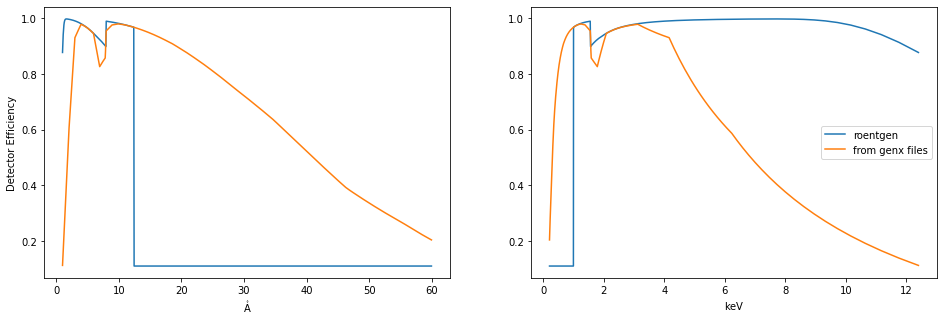

In [71]:
plt.figure(figsize=(16,5))
plt.subplot(121)
with quantity_support():
    plt.plot(wavelength, response.response(energy), label=f'roentgen')
    plt.plot(wavelength, chan.detector_efficiency * chan.filter_transmission, label='from genx files')
plt.ylabel(f'Detector Efficiency')
plt.subplot(122)
with quantity_support():
    plt.plot(energy.to('keV'), response.response(energy), label=f'roentgen')
    plt.plot(energy.to('keV'), chan.detector_efficiency * chan.filter_transmission, label='from genx files')
plt.legend()

## Pinhole Images

## Questions

* What materials are in the optical path of our detector? Currently, just assuming Al (for dispersed image)
* What are the materials for the pinhole filters? (is proposal correct?)
* What are the associated thicknesses of each of these components?
* When it comes to modeling the detector, should this be absorption?
* What is the quantum efficiency of the detector?
    * QE is probability of observing photon?
    * Or is it the conversion from photon to electron different?
    * Or different active involvement of the detector?

Text(0.5, 1.0, 'Aluminum')

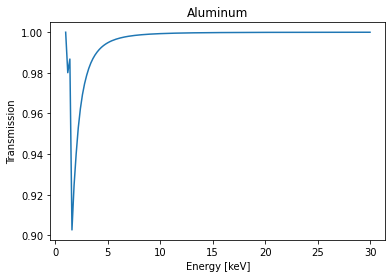

In [81]:
al = Material('Al', 100 * u.nm)
energy = u.Quantity(np.arange(.99, 30, 0.2), 'keV')

plt.plot(energy, al.transmission(energy))
plt.ylabel('Transmission')
plt.xlabel('Energy [' + str(energy.unit) + ']')
plt.title(al.name)

In [84]:
(const.h  * const.c / (50*u.eV)).to('Angstrom')

<Quantity 247.96839687 Angstrom>

In [86]:
(const.h * const.c).to('keV angstrom')

<Quantity 12.39841984 Angstrom keV>

### Sandbox

In [48]:
import astropy.units as u
import astropy.constants as const
import matplotlib.pyplot as plt
import numpy as np
from roentgen.absorption import Material

al = Material('Al',100*u.nm)

wavelength = np.arange(1,60,1) * u .angstrom
energy = const.h * const.c / wavelength

transmission = al.transmission(energy)
mac = al.mass_attenuation_coefficient.func(energy)

In [52]:
mac

<Quantity [1.39335815e+01, 1.04943595e+02, 3.29092992e+02, 7.21052493e+02,
           1.29348632e+03, 2.07863124e+03, 2.97403938e+03, 3.68515040e+02,
           5.04613440e+02, 6.68191163e+02, 8.61411384e+02, 1.08621460e+03,
           1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
           1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
           1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
           1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
           1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
           1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
           1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
           1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
           1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
           1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
           1.00000000e+00

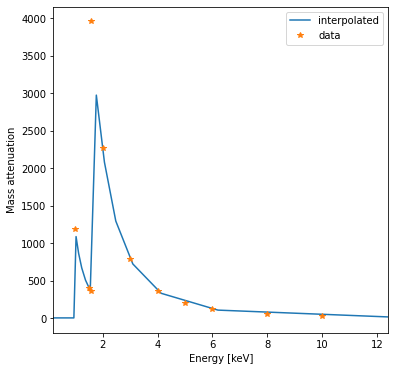

In [50]:
plt.figure(figsize=(6,6))
plt.subplot(111)
plt.plot(energy.to('keV'),mac, label='interpolated')
plt.plot(al.mass_attenuation_coefficient.energy, al.mass_attenuation_coefficient.data, marker='*', ls='', label='data')
plt.xlim(energy[[-1,0]].to('keV').value)
plt.ylabel('Mass attenuation')
plt.xlabel('Energy [keV]')
plt.legend()

Text(0, 0.5, 'Transmission')

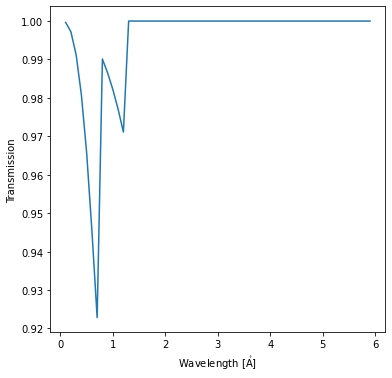

In [54]:
plt.figure(figsize=(6,6))
plt.subplot(111)
plt.plot(wavelength.to('nm'), transmission)
plt.xlabel('Wavelength [$\mathrm{\mathring{A}}$]')
plt.ylabel('Transmission')

In [59]:
(100 * u.nm).to('um')

<Quantity 0.1 um>

In [57]:
wavelength.to('nm')

<Quantity [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
           1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
           2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
           4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
           5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9] nm>